In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import csv

import contractions
import nltk
from nltk.text import Text
from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import spacy

import re 

In [2]:
df = pd.read_csv('sg_green.csv')

In [3]:
df

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card,viewCount,vibe
0,https://twitter.com/khainad/status/16307166453...,2023-02-28 23:48:40+00:00,girl contracted covid month old wife taking ca...,girl contracted covid month old wife taking ca...,1630716645357522944,https://twitter.com/khainad,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN
1,https://twitter.com/MattHarrisEdD/status/16306...,2023-02-28 22:30:03+00:00,tip cybersafety family edtech globaled elearni...,tip cybersafety family edtech globaled elearni...,1630696860598915075,https://twitter.com/MattHarrisEdD,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,"['Edtech', 'GlobalEd', 'elearning', 'edutech']",NaN,SummaryCard(title='5 Tips for CyberSafety for ...,72.0,NaN
2,https://twitter.com/Chindyagung1/status/163066...,2023-02-28 20:33:20+00:00,algodtrading imagine take vaccinate survive su...,algodtrading imagine take vaccinate survive su...,1630667487745576960,https://twitter.com/Chindyagung1,0,0,0,0,...,1.630642e+18,https://twitter.com/AlgodTrading,"[User(username='AlgodTrading', id=117864028365...",NaN,NaN,NaN,NaN,NaN,20.0,NaN
3,https://twitter.com/mfame_guru/status/16306590...,2023-02-28 19:59:48+00:00,hong kong scrapping mask mandate wednesday nea...,hong kong scrapping mask mandate wednesday nea...,1630659051599065088,https://twitter.com/mfame_guru,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SummaryCard(title='Hong Kong Ends One of World...,16.0,NaN
4,https://twitter.com/mfame_guru/status/16306565...,2023-02-28 19:50:00+00:00,geopolitical uncertainty brought ukrainian war...,geopolitical uncertainty brought ukrainian war...,1630656583733596160,https://twitter.com/mfame_guru,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SummaryCard(title='What are Business Leaders D...,7.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,https://twitter.com/JosephJohnAdam1/status/162...,2023-02-01 02:16:24+00:00,jojofromjerz covid death week u america lost,jojofromjerz covid death week u america lost,1620606963108442112,https://twitter.com/JosephJohnAdam1,0,0,0,0,...,1.620583e+18,https://twitter.com/JoJoFromJerz,"[User(username='JoJoFromJerz', id=818893114979...","Coordinates(longitude=103.817832999913, latitu...","Place(id='5f1f473ed6455f55', fullName='North-E...",NaN,NaN,NaN,55.0,NaN
140,https://twitter.com/BruceWeeWM/status/16305534...,2023-02-28 13:00:17+00:00,zaydlaiq yazidshayau really show one one news ...,zaydlaiq yazidshayau really show one one news ...,1630553475183517697,https://twitter.com/BruceWeeWM,1,0,6,0,...,1.630518e+18,https://twitter.com/zaydlaiq,"[User(username='zaydlaiq', id=1610648061788798...",NaN,NaN,NaN,NaN,NaN,175.0,NaN
141,https://twitter.com/connected2india/status/163...,2023-02-28 12:03:00+00:00,hong kong lift mask mandate year hongkong covi...,hong kong lift mask mandate year hongkong covi...,1630539058844958720,https://twitter.com/connected2india,0,1,0,0,...,NaN,NaN,"[User(username='connected2india', id=722984730...",NaN,NaN,"['HongKong', 'covidnews', 'COVID19', 'hongkong...",NaN,SummaryCard(title='Hong Kong lifts mask mandat...,61.0,NaN
142,https://twitter.com/ChannelNewsAsia/status/163...,2023-02-28 00:08:34+00:00,coronavirus origin still mystery year pandemic,coronavirus origin still mystery year pandemic,1630359268430839809,https://twitter.com/ChannelNewsAsia,10,17,20,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16140.0,NaN


In [4]:
df.isna().sum()

url                   0
date                  0
rawContent            0
renderedContent       0
id                    0
user                  0
replyCount            0
retweetCount          0
likeCount             0
quoteCount            0
conversationId        0
lang                  0
source                0
sourceUrl             0
sourceLabel           0
links               101
media               114
retweetedTweet      144
quotedTweet         129
inReplyToTweetId     99
inReplyToUser        99
mentionedUsers       94
coordinates          78
place                78
hashtags            126
cashtags            144
card                116
viewCount             0
vibe                144
dtype: int64

In [5]:
df['rawContent'].fillna('', inplace=True)
df['renderedContent'].fillna('', inplace=True)

In [6]:
## remove specific word HTTP
df['rawContent'] = df['rawContent'].str.replace('covid', '')
df['rawContent'] = df['rawContent'].str.replace('coronavirus', '')

df['renderedContent'] = df['renderedContent'].str.replace('covid', '')
df['renderedContent'] = df['renderedContent'].str.replace('coronavirus', '')

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 10)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

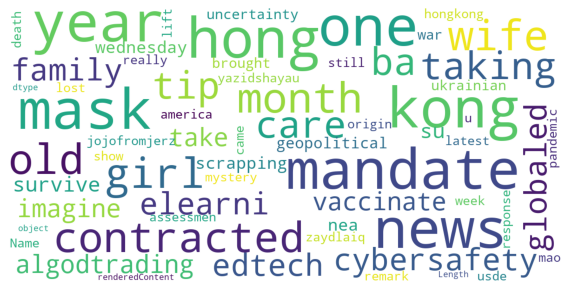

In [8]:
show_wordcloud(df["renderedContent"])

In [9]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [10]:
data = df['renderedContent'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['girl', 'contracted', 'month', 'old', 'wife', 'taking', 'care', 'back', 'best']


## Building Bi-gram and Tri-gram Models

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [13]:
data_words_bigrams = make_bigrams(data_words)
data_words_bigrams

[['girl',
  'contracted',
  'month',
  'old',
  'wife',
  'taking',
  'care',
  'back',
  'best'],
 ['tip',
  'cybersafety',
  'family',
  'edtech',
  'globaled',
  'elearning',
  'edutech'],
 ['algodtrading',
  'imagine',
  'take',
  'vaccinate',
  'survive',
  'super',
  'human',
  'tip',
  'everyone',
  'take',
  'vaccinate',
  'give',
  'dead',
  'sentance',
  'unvaccinated',
  'people',
  'survive',
  'shall',
  'survive',
  'vaccination'],
 ['hong_kong',
  'scrapping',
  'mask',
  'mandate',
  'wednesday',
  'nearly',
  'three',
  'year',
  'strict',
  'measure',
  'imposed',
  'financial',
  'hub',
  'report',
  'dw',
  'announce',
  'masking',
  'requirement',
  'completely',
  'canceled',
  'starting',
  'tomorrow',
  'march'],
 ['geopolitical',
  'uncertainty',
  'brought',
  'ukrainian',
  'war',
  'continuous',
  'disruption',
  'escalation',
  'climate',
  'change',
  'effect',
  'pushed',
  'business',
  'leader',
  'put',
  'greater',
  'focus',
  'sustainability',
  'ag

In [14]:
data_words_trigrams = make_trigrams(data_words)
data_words_trigrams

[['girl',
  'contracted',
  'month',
  'old',
  'wife',
  'taking',
  'care',
  'back',
  'best'],
 ['tip',
  'cybersafety',
  'family',
  'edtech',
  'globaled',
  'elearning',
  'edutech'],
 ['algodtrading',
  'imagine',
  'take',
  'vaccinate',
  'survive',
  'super',
  'human',
  'tip',
  'everyone',
  'take',
  'vaccinate',
  'give',
  'dead',
  'sentance',
  'unvaccinated',
  'people',
  'survive',
  'shall',
  'survive',
  'vaccination'],
 ['hong_kong',
  'scrapping',
  'mask',
  'mandate',
  'wednesday',
  'nearly',
  'three',
  'year',
  'strict',
  'measure',
  'imposed',
  'financial',
  'hub',
  'report',
  'dw',
  'announce',
  'masking',
  'requirement',
  'completely',
  'canceled',
  'starting',
  'tomorrow',
  'march'],
 ['geopolitical',
  'uncertainty',
  'brought',
  'ukrainian',
  'war',
  'continuous',
  'disruption',
  'escalation',
  'climate',
  'change',
  'effect',
  'pushed',
  'business',
  'leader',
  'put',
  'greater',
  'focus',
  'sustainability',
  'ag

## Building rough LDA model 

In [15]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words_trigrams)

# Create Corpus
texts = data_words_trigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


In [16]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [17]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"singapore" + 0.006*"opposition" + 0.006*"care" + 0.006*"well" + '
  '0.006*"game" + 0.004*"pandemic" + 0.004*"year" + 0.004*"risk" + '
  '0.004*"need" + 0.004*"pap"'),
 (1,
  '0.010*"time" + 0.008*"conspiracy" + 0.008*"theory" + 0.005*"finally" + '
  '0.005*"world" + 0.005*"well" + 0.005*"people" + 0.005*"second" + '
  '0.005*"get" + 0.005*"think"'),
 (2,
  '0.008*"year" + 0.007*"india" + 0.007*"singapore" + 0.006*"pandemic" + '
  '0.006*"due" + 0.006*"still" + 0.006*"china" + 0.006*"test" + 0.006*"day" + '
  '0.005*"would"'),
 (3,
  '0.015*"mask" + 0.011*"singapore" + 0.010*"hong_kong" + 0.010*"scrap" + '
  '0.009*"mandate" + 0.007*"year" + 0.007*"one" + 0.006*"day" + 0.006*"march" '
  '+ 0.005*"small"'),
 (4,
  '0.009*"year" + 0.009*"must" + 0.009*"china" + 0.009*"say" + 0.009*"origin" '
  '+ 0.008*"envoy" + 0.008*"honest" + 0.005*"get" + 0.005*"survive" + '
  '0.005*"vaccine"')]


In [18]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.542615384066255


## Tuning based on number of topics

In [19]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
       
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    # Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, 
                                         coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [20]:
# Can take a long time to run. In this case we are going to k_max=14.
import datetime
print(datetime.datetime.now())

from gensim.models import CoherenceModel

coherence_scores = []
model_topics = []

for k in range(2, 20):
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word,k=k) 
    model_topics.append(k)    
    coherence_scores.append(cv)    
    print("#Topics: " + str(k) + ", Score: " + str(coherence_scores[-1]))

print(datetime.datetime.now())

2023-03-12 01:43:17.659661
#Topics: 2, Score: 0.5251420964364499
#Topics: 3, Score: 0.5066802383078204
#Topics: 4, Score: 0.5336078157954941
#Topics: 5, Score: 0.542615384066255
#Topics: 6, Score: 0.5457181421854977
#Topics: 7, Score: 0.5312855647168069
#Topics: 8, Score: 0.5135482256861671
#Topics: 9, Score: 0.5099672627043815
#Topics: 10, Score: 0.5239855658450387
#Topics: 11, Score: 0.5141491944260916
#Topics: 12, Score: 0.4775697774597909
#Topics: 13, Score: 0.46951935917939686
#Topics: 14, Score: 0.48247712881574467
#Topics: 15, Score: 0.4295405809723514
#Topics: 16, Score: 0.41747795313180514
#Topics: 17, Score: 0.4128536904946549
#Topics: 18, Score: 0.4514567173282537
#Topics: 19, Score: 0.42988882891684704
2023-03-12 01:43:55.982256


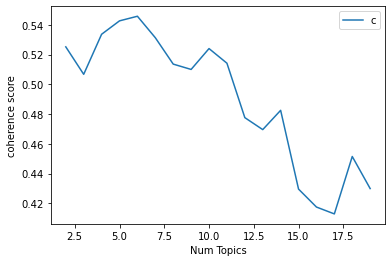

In [21]:
# Show graph

import matplotlib.pyplot as plt

limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence score"), loc='best')
plt.show()

In [22]:
end here

SyntaxError: invalid syntax (<ipython-input-22-9bcc9ab561c7>, line 1)

### Final Model

In [23]:
num_topics = 6

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)

In [24]:
score = CoherenceModel(model=lda_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
score.get_coherence()

0.5457181421854977

In [25]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./lda_model/sg_green_lda_vis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './lda_vis/sg_green_lda_vis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.111200 -0.103650       1        1  24.286862
3      0.075174  0.126856       2        1  19.650188
2     -0.087630  0.006415       3        1  17.249511
4     -0.082590 -0.031735       4        1  14.647990
1     -0.000273 -0.002277       5        1  12.251015
0     -0.015881  0.004390       6        1  11.914435, topic_info=          Term      Freq     Total Category  logprob  loglift
254     origin  5.000000  5.000000  Default  30.0000  30.0000
279       must  4.000000  4.000000  Default  29.0000  29.0000
146      china  9.000000  9.000000  Default  28.0000  28.0000
550      envoy  3.000000  3.000000  Default  27.0000  27.0000
551     honest  3.000000  3.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
334         le  0.631282  3.026366   Topic6  -5.9219   0.5601
253       need  0.631280  4.329973   Topic6  -5.9219   0.2019
2         care  0.631279  2.420696   Topic6  -5.9219   0.7834
884       made  0.631276  1.789133   Topic6  -5.9219   1.0857
883  falsehood  0.631206  2.307432   Topic6  -5.9220   0.8312

[333 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
311       4  0.564760    abetting
899       2  0.557397    actually
899       5  0.557397    actually
900       5  0.869405  additional
312       1  0.279172        also
...     ...       ...         ...
53        5  0.074743        year
53        6  0.074743        year
325       1  0.412271         yes
325       4  0.412271         yes
325       5  0.412271         yes

[449 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 3, 5, 2, 1])